Note: If you are using the Google Colab and want to use tensorflow < 2: you will have to downgrade using this link. https://colab.research.google.com/notebooks/tensorflow_version.ipynb

**Name:**   Sheikh Ghulam Muhammad Ali

**Roll Number:**   2020-10-0186

# Sentiment Analysis on IMDB Movie Review dataset

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. We will be using LSTMs and Bi-directional LSTMs to predict two classes - positive or negative sentiment.


You will be reading the dataset from here: https://drive.google.com/file/d/127PCwycL0oToSF6l-c2oFuBkacYsmlgK/view?usp=sharing

You can use this blog for understanding: https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e

In [0]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB


In [0]:
import numpy as np 
import pandas as pd 
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Conv1D, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
#imports added by me
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


All the relevant libraries are imported. 
You are free to change as you please. 
Using the GPU backend is recommended as LSTMs are computationally expensive to train.



## Data handling - exploration and cleaning





1.   You are expected to read the dataset into a dataframe.
2.   This is a real world dataset and you will be expected to clean the dataset.

1.   This includes removing trailing spaces and HTML tags.






In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/DL Assignments/PA 06/IMDB Dataset.csv'
df = pd.read_csv(path)

In [0]:
df.shape

(50000, 2)

In [0]:
df.head(8)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative


### Data Cleaning - write the techniques you employed and the achieved results

In [0]:
# WRITE CODE HERE
# Sample code:
df['review'] = df['review'].str.replace('<br />', '')
df['review'] = df['review'].str.replace('Ã', 'a')
df['review'] = df['review'].str.replace('©', 'c')

In [0]:
df['review'] = df['review'].apply(lambda x: x.lower())                                    #convert text to lower case
df['review'] = df['review'].str.replace('[{}]'.format(string.punctuation), '')            #remove punctuation marks
df['review'] = df['review'].str.replace('[{}]'.format(string.digits), '')                 #remove digits (as they are insignificant for our analysis)

Write about the techniques used to clean:

I analyzed provided csv file. Initially, I used standard pandas dataframe methods available to clean the data but it has variation. Further this approach is messy and requires us to manually specify and clean data.

For better approach, I also imported string library and used its methods. First, I converted all strings to lower case to remove redundancy. After that, I removed punctuation marks as they are pretty insiginificant in given context of sentiment analysis. In the end, I removed all digits present in data as they won't be of any help in given context of sentiment identification. Later, stop words have also been removed as they do not play major role in order to achieve end goal of our models.

### Data Exploration



1.   You are required to report the total number of distinct tokens present in the data set.
2.   Find out the minimum and max length of a review.

An integral part of visualization when it comes to textual data is the generating of a word cloud.

1.   
This task is open-ended and you can use any library of your choice. 
NLTK is one such library. 
2.   
Make sure to keep note of stop words.

##Example:


![alt text](https://getthematic.com/wp-content/uploads/2018/03/Harris-Word-Cloud-e1522406279125.png)




In [0]:
df['review'] = df['review'].apply(word_tokenize)      #tokenize based on words
#df.head()

Removing stop words here from the data and keeping there record

In [0]:
stop = stopwords.words('english')                     #remove english stop words from tokized data
df['review'] = df['review'].apply(lambda x: [item for item in x if item not in stop])

Number of distinct tokens in dataset after data cleaning:

In [0]:
uniqueWords = set()
df['review'].apply(uniqueWords.update)
num_uniqueWords = len(uniqueWords)
print(num_uniqueWords)

215321


Maximum and minimum length of a review:

In [0]:
#WRITE CODE HERE
maxlength = df.review.map(len).max()          #maxlength of a review
print(maxlength)
minlength = df.review.map(len).min()          #minlength of a review
print(minlength)

1420
3


In [0]:
#join tokenised data to create sentences as wordCloud inputs a single complete sentence containing whole dataset
allText = [" ".join(text) for text in df['review']]             #joins words on a single row of dataframe to form a sentence
allText = " ".join(allText)                                     #joins each row of dataframe
#allText[:500]

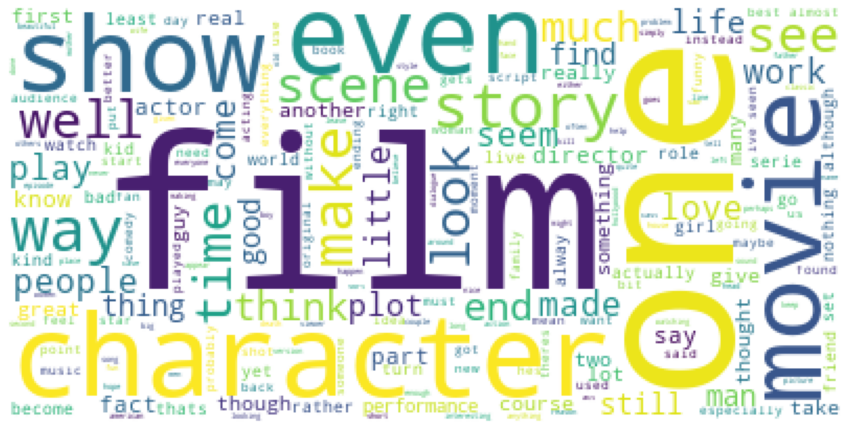

In [0]:
wordcloud = WordCloud(background_color="white").generate(allText)

plt.figure(figsize = (15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Model processing

You can use a 70:30 train/test split.
The labels are 'positive' and negative, you should assign them integers 0 or 1 for further processing.

In [0]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
#import matplotlib.pyplot as plt

In [0]:
#Reassign labels
df['sentiment'] = df['sentiment'].replace(to_replace = 'positive', value=1)
df['sentiment'] = df['sentiment'].replace(to_replace = 'negative', value=0)
#print(df['sentiment'].dtypes)

In [0]:
df.head(8)

,review,sentiment
0,"[one, reviewers, mentioned, watching, oz, epis...",1
1,"[wonderful, little, production, filming, techn...",1
2,"[thought, wonderful, way, spend, time, hot, su...",1
3,"[basically, theres, family, little, boy, jake,...",0
4,"[petter, matteis, love, time, money, visually,...",1
5,"[probably, alltime, favorite, movie, story, se...",1
6,"[sure, would, like, see, resurrection, dated, ...",1
7,"[show, amazing, fresh, innovative, idea, first...",0


In [0]:
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'],test_size = 0.3, shuffle=True)

### Tokenizer
You will need to use fit a tokenizer over your training and testing data.

What does a tokenizer do?
It creates a dictionary of word to integer mappings. It updates internal vocabulary based on a list of texts. You should read up on the documentation before diving into the code. 

You will also be using the the text_to_sequence function will return integers based on a respective tokenizer.

Make sure you **pad** your sequences to max length using sequence.pad_sequences()




In [0]:
# WRITE CODE HERE
t = Tokenizer(num_words= num_uniqueWords)
t.fit_on_texts(x_train)

In [0]:
x_train_sequence = t.texts_to_sequences(x_train)
x_test_sequence = t.texts_to_sequences(x_test)

In [0]:
x_train_pad = sequence.pad_sequences(x_train_sequence, maxlen = maxlength, padding='pre')
x_test_pad = sequence.pad_sequences(x_test_sequence, maxlen = maxlength, padding='pre')

### Embedding layer
You will be importing the embedding layer from Keras.
Embedding layers are common place when handling textual data. 
Word embeddings provide a dense representation of words and their relative meanings.

#### How do they work - via Stack Overflow
Link: https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

The output vectors are not computed from the input using any mathematical operation. Instead, each input integer is used as the index to access a table that contains all posible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).

The most common application of this layer is for text processing. Let's see a simple example. Our training set consists only of two phrases:

Hope to see you soon

Nice to see you again

So we can encode these phrases by assigning each word a unique integer number (by order of appearance in our training dataset for example). Then our phrases could be rewritten as:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Now imagine we want to train a network whose first layer is an embeding layer. In this case, we should initialize it as follows:

Embedding(7, 2, input_length=5)

The first argument (7) is the number of distinct words in the training set. The second argument (2) indicates the size of the embedding vectors. The input_length argumet, of course, determines the size of each input sequence.

Once the network has been trained, we can get the weights of the embedding layer, which in this case will be of size (7, 2) and can be thought as the table used to map integers to embedding vectors.


### Model Engineering

You will be required to engineer three types of models from scratch.

1.   Using LSTMs
2.   Bi-directional LSTMs

1.   A model with less than 10,000 parameters - the lower the parameters, higher the score (provided accuracy is good)


For each model:

1.   You will be reporting graphs for validation accuracy and training loss.
2.   What hyper-parameters, loss functions, optimizations, initializations were used. This should be clearly stated in your analysis.

~90 percent and above is the desired accuracy. 

For model 3, CLEARLY report the number of parameters.




In [0]:
# CODE HERE

# Some example code to help you get started
# X_train is your training data 
# input_dim is your dictionary length, output_dim is the length is the dimension of the dense embedding, you can choose whatever works best for you, starting with 2.
lstm_model = Sequential()
lstm_model.add(Embedding(num_uniqueWords, 2, input_length= x_train_pad.shape[1]))
lstm_model.add(LSTM(200))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# You can choose to complete this model per your choice
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1420, 2)           430642    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               162400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 593,243
Trainable params: 593,243
Non-trainable params: 0
_________________________________________________________________


In [0]:
BATCH_SIZE = 1048
EPOCHS = 8

In [0]:
lstm_hist = lstm_model.fit(x_train_pad,
                           y_train,
                           batch_size = 1048,
                           epochs = 8,
                           validation_data = [x_test_pad, y_test],
                           use_multiprocessing = True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 35000 samples, validate on 15000 samples
Epoch 1/8
35000/35000 [==============================] - 110s 3ms/step - loss: 0.6974 - accuracy: 0.5090 - val_loss: 0.6910 - val_accuracy: 0.5011
Epoch 2/8
35000/35000 [==============================] - 110s 3ms/step - loss: 0.6839 - accuracy: 0.5949 - val_loss: 0.6725 - val_accuracy: 0.5069
Epoch 3/8
35000/35000 [==============================] - 110s 3ms/step - loss: 0.6529 - accuracy: 0.6163 - val_loss: 0.6253 - val_accuracy: 0.6526
Epoch 4/8
35000/35000 [==============================] - 110s 3ms/step - loss: 0.4812 - accuracy: 0.8060 - val_loss: 0.4431 - val_accuracy: 0.8304
Epoch 5/8
35000/35000 [==============================] - 110s 3ms/step - loss: 0.4879 - accuracy: 0.8000 - val_loss: 0.5553 - val_accuracy: 0.7391
Epoch 6/8
35000/35000 [==============================] - 109s 3ms/step - loss: 0.3566 - accuracy: 0.8646 - val_loss: 0.3434 - val_accuracy: 0.8567
Epoch 7/8
35000/35000 [==============================] - 109s 3ms/st

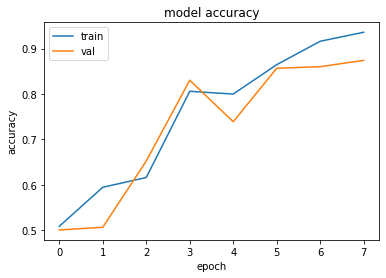

In [0]:
#validation accuracy of lstm model
plt.plot(lstm_hist.history['accuracy'])
plt.plot(lstm_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

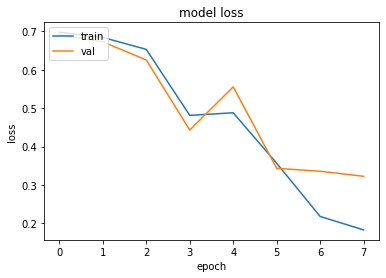

In [0]:
#training loss of a lstm model
plt.plot(lstm_hist.history['loss'])
plt.plot(lstm_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
#Bi-directional LSTM
bidir_lstm_model = Sequential()
bidir_lstm_model.add(Embedding(num_uniqueWords, 2, input_length= x_train_pad.shape[1]))
bidir_lstm_model.add(Bidirectional(LSTM(200)))
bidir_lstm_model.add(Dropout(0.4))
bidir_lstm_model.add(Dense(1, activation='sigmoid'))
bidir_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

bidir_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1420, 2)           430642    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               324800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 401       
Total params: 755,843
Trainable params: 755,843
Non-trainable params: 0
_________________________________________________________________


In [0]:
bidir_lstm_hist = bidir_lstm_model.fit(x_train_pad,
                           y_train,
                           batch_size = 768,
                           epochs = 8,
                           validation_data = [x_test_pad, y_test],
                           use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 35000 samples, validate on 15000 samples
Epoch 1/8
35000/35000 [==============================] - 278s 8ms/step - loss: 0.6931 - accuracy: 0.5226 - val_loss: 0.6885 - val_accuracy: 0.6824
Epoch 2/8
35000/35000 [==============================] - 278s 8ms/step - loss: 0.6812 - accuracy: 0.7055 - val_loss: 0.6729 - val_accuracy: 0.7377
Epoch 3/8
35000/35000 [==============================] - 278s 8ms/step - loss: 0.6562 - accuracy: 0.7628 - val_loss: 0.5260 - val_accuracy: 0.7902
Epoch 4/8
35000/35000 [==============================] - 277s 8ms/step - loss: 0.4556 - accuracy: 0.8336 - val_loss: 0.3762 - val_accuracy: 0.8363
Epoch 5/8
35000/35000 [==============================] - 278s 8ms/step - loss: 0.2836 - accuracy: 0.8895 - val_loss: 0.3727 - val_accuracy: 0.8396
Epoch 6/8
35000/35000 [==============================] - 277s 8ms/step - loss: 0.3599 - accuracy: 0.8760 - val_loss: 0.4048 - val_accuracy: 0.8305
Epoch 7/8
35000/35000 [==============================] - 276s 8ms/st

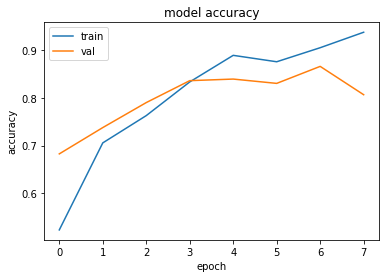

In [0]:
#validation accuracy of Bi-directional lstm model
plt.plot(bidir_lstm_hist.history['accuracy'])
plt.plot(bidir_lstm_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

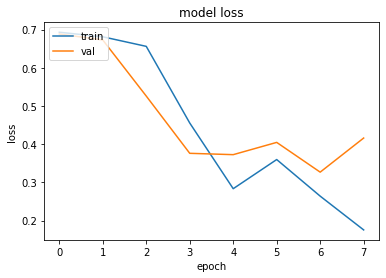

In [0]:
#training loss of Bi-directional lstm model
plt.plot(bidir_lstm_hist.history['loss'])
plt.plot(bidir_lstm_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
#3rd costum model with less than 10k params
costum_model = Sequential()
costum_model.add(Embedding(2000, 2, input_length= x_train_pad.shape[1]))
costum_model.add(LSTM(25, return_sequences=True))
costum_model.add(Dropout(0.4))
costum_model.add(LSTM(18))
costum_model.add(Dropout(0.4))
costum_model.add(Dense(1, activation='sigmoid'))
costum_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# You can choose to complete this model per your choice
costum_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1420, 2)           4000      
_________________________________________________________________
lstm_8 (LSTM)                (None, 1420, 25)          2800      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1420, 25)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 18)                3168      
_________________________________________________________________
dropout_9 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 19        
Total params: 9,987
Trainable params: 9,987
Non-trainable params: 0
____________________________________________________

In [0]:
costum_token = Tokenizer(num_words= 2000)
costum_token.fit_on_texts(x_train)

In [0]:
x_costum_train_sequence = costum_token.texts_to_sequences(x_train)
x_costum_test_sequence = costum_token.texts_to_sequences(x_test)

In [0]:
x_costum_train_pad = sequence.pad_sequences(x_costum_train_sequence, maxlen = maxlength, padding='pre')
x_costum_test_pad = sequence.pad_sequences(x_costum_test_sequence, maxlen = maxlength, padding='pre')

In [0]:
costum_model_hist = costum_model.fit(x_costum_train_pad,
                           y_train,
                           batch_size = 4096,
                           epochs = 22,
                           validation_data = [x_costum_test_pad, y_test],
                           use_multiprocessing=True)

Train on 35000 samples, validate on 15000 samples
Epoch 1/22
35000/35000 [==============================] - 58s 2ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 2/22
35000/35000 [==============================] - 58s 2ms/step - loss: 0.6930 - accuracy: 0.5245 - val_loss: 0.6927 - val_accuracy: 0.5239
Epoch 3/22
35000/35000 [==============================] - 57s 2ms/step - loss: 0.6919 - accuracy: 0.6000 - val_loss: 0.6899 - val_accuracy: 0.6709
Epoch 4/22
35000/35000 [==============================] - 57s 2ms/step - loss: 0.6804 - accuracy: 0.6616 - val_loss: 0.6600 - val_accuracy: 0.5650
Epoch 5/22
35000/35000 [==============================] - 58s 2ms/step - loss: 0.6327 - accuracy: 0.7055 - val_loss: 0.5858 - val_accuracy: 0.6943
Epoch 6/22
35000/35000 [==============================] - 58s 2ms/step - loss: 0.5210 - accuracy: 0.7675 - val_loss: 0.4650 - val_accuracy: 0.7913
Epoch 7/22
35000/35000 [==============================] - 58s 2ms/st

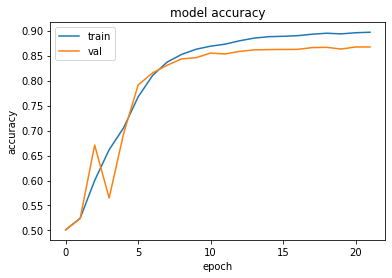

In [0]:
#validation accuracy of costum 10k model
plt.plot(costum_model_hist.history['accuracy'])
plt.plot(costum_model_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

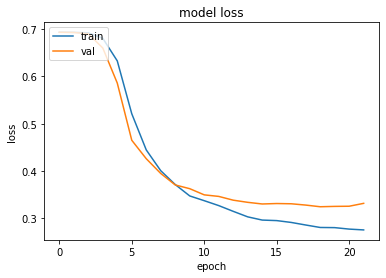

In [0]:
#training loss of costum 10k model
plt.plot(costum_model_hist.history['loss'])
plt.plot(costum_model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Predictions. For your best performing model

Come up with ten sample sentences NOT part of the original data set. 
Use model.predict() to generate predictions and report positive or negative sentiment.

In [0]:
#sample reviews taken from rotten tomatoes
sampleReviews = {'review': ["Although the idea seemed nice but they just didn't execute it properly. It was a huge let down for me",  #-ve
                            "I went into the movie with low expectations but I was pleasantly surprised. It was an enjoyable experience.",        #+ve
                            "This movie did not live up to the hype. Why the hell were people excited about THIS?",  #-ve
                            "Oh man I had an amazing time from start to finish. What a movie",     #+ve
                            "Absolutely recommended to appreciate where the creative currents of that forgotten new Spanish cinema has gone.",      #+ve
                            "Angelina Jolie is stunning to look at but there's just no tension to be derived from waiting to see whether Lara or the bad guys will get their hands on the fabled Pandora's box first. ",      #-ve
                            "Although the movie started slow at first, it definitely picked up towards the end. Overall a nice movie",        #+ve
                            "This movie was not great but you could definitely watch it if you had nothing better to kill time with",                 #-ve
                            "The film's insistence on keeping the stakes low throughout is probably its key strength.",                             #-ve
                            "A highly derivative narrative seems even more deadened thanks to their switch to a teenage boy's perspective, but some impressive visuals are sometimes enough to distract from the predictable proceedings."    #-ve
                             ]}

In [0]:
sample_df = pd.DataFrame(sampleReviews)

In [0]:
sample_tokens = t.fit_on_texts(sample_df['review'])
sample_tokens = t.texts_to_sequences(sample_df['review'])
sample_tokens = sequence.pad_sequences(sample_tokens, maxlen = maxlength, padding='pre')

LSTM Model predictions (93% accuracy):

prediction output on given sample is in range of 0.002 - 95. Model has correct probability for 8 sentences. However, it has variation in results. Model has been trained w/o overfitting. One reason could be the length of sentences. sample sentences are pretty short which could be the reason of variation in output range of model.

In [0]:
lstm_pred = lstm_model.predict(np.array(sample_tokens))
print(lstm_pred)

[[0.6913527 ]
 [0.9217897 ]
 [0.79442096]
 [0.8963654 ]
 [0.9521565 ]
 [0.07313947]
 [0.8882717 ]
 [0.7427249 ]
 [0.93464476]
 [0.00280957]]


Bi-LSTM Model predictions (93% accuracy):

prediction output on given sample is in range of 0.05 - 75. Model has correct probability for 9 sentences. It has less variation in results and relatively more stable then previous model. However, during training, model was highly volatile, as it can be seen from its graphs. It seems that it is learning at high rate during processing but gives stable and better output.

In [0]:
bidir_lstm_pred = bidir_lstm_model.predict(np.array(sample_tokens))
print(bidir_lstm_pred)

[[0.6423854 ]
 [0.7576933 ]
 [0.2638499 ]
 [0.6924829 ]
 [0.70216984]
 [0.29052076]
 [0.7494982 ]
 [0.3998304 ]
 [0.72085744]
 [0.05502928]]


In [0]:
#costum_sample_tokens = costum_token.fit_on_texts(sample_df['review'])
costum_sample_tokens = costum_token.texts_to_sequences(sample_df['review'])
costum_sample_tokens = sequence.pad_sequences(costum_sample_tokens, maxlen = maxlength, padding='pre')

Costum Model predictions (89% accuracy):

prediction output on given sample is in range of 0.3 - 0.8. Model has correct probability for 6 sentences. It has less variation in results and relatively more stable then previous model. However, its output sphere is highly limited as its tokenizer has been limited to identify 2000 words. 
My approach and architecture of models makes it easier to further changes. It is highly stable and sophisticated in output but it has limited domain of working correctly due to limited tokenization.

In [0]:
costum_model_pred = costum_model.predict(np.array(costum_sample_tokens))
print(costum_model_pred)

[[0.35391662]
 [0.5300457 ]
 [0.42879924]
 [0.44784194]
 [0.74349785]
 [0.50656074]
 [0.66168624]
 [0.5961367 ]
 [0.38971612]
 [0.8191933 ]]
